# Physics 231: Final Project
## Adiabatic Evolution of the Anharmonic Oscillator

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

### Defining the Ladder Operators in the Harmonic Oscillator Basis

__Note:__ n sets the size of the Hilbert Space spanned by the basis states $\{|0\rangle,|1\rangle,...,|n-1\rangle\}$.

In [2]:
def op_a(n):
    mat = np.zeros((n, n))
    for i in range(n-1):
        mat[i][i+1] = np.sqrt(i+1)
    return mat

def op_adag(n):
    mat = np.zeros((n, n))
    for i in range(n-1):
        mat[i+1][i] = np.sqrt(i+1)
    return mat

def op_n(n):
    a = op_a(n)
    adag = op_adag(n)
    mat = np.dot(adag,a)
    return mat

In [3]:
a = op_a(5)
b = op_adag(5)
print(np.dot(a,b)-np.dot(b,a)) #expect [a,adag] = 1
print(op_n(5))

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. -4.]]
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 4.]]


__Note:__ The error in the last row is a result of the fact that the originally infinite Hilbert Space has been truncated.

### Defining the x,p in terms of Dagger Operators

$$x = \sqrt{\frac{\hbar}{2m\omega}}(a+a^+)$$

$$p = -i\sqrt{\frac{m\omega\hbar}{2}}(a-a^+)$$

#### We will be setting $\hbar = m = \omega = 1$

In [4]:
def op_x(n):
    mat = np.sqrt(1/2)*(op_a(n) + op_adag(n))
    return mat

def op_p(n):
    mat = (-1j)*np.sqrt(1/2)*(op_a(n) - op_adag(n))
    return mat

In [5]:
x = op_x(5)
p = op_p(5)
print(np.imag(np.dot(x,p)-np.dot(p,x))) # expect [x,p] = ihbar

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. -4.]]


#### Test: Is $x^2$ the same from definition of x and dagger operators

In [6]:
# FROM DAGGER OPERATORS
a = op_a(5)
adag = op_adag(5)
# x2 = 0.5*((np.dot(a,a)+np.dot(adag,adag)+np.eye(5)+2*op_n(5))) # using aa^+ = 1 + n
x2 = 0.5*((np.dot(a,a)+np.dot(adag,adag)+np.dot(adag,a)+np.dot(a,adag)))
x2

array([[0.5       , 0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 1.5       , 0.        , 1.22474487, 0.        ],
       [0.70710678, 0.        , 2.5       , 0.        , 1.73205081],
       [0.        , 1.22474487, 0.        , 3.5       , 0.        ],
       [0.        , 0.        , 1.73205081, 0.        , 2.        ]])

In [7]:
# FROM DEFINITION OF x
x = op_x(5)
x2_test = np.dot(x,x)
x2_test

array([[0.5       , 0.        , 0.70710678, 0.        , 0.        ],
       [0.        , 1.5       , 0.        , 1.22474487, 0.        ],
       [0.70710678, 0.        , 2.5       , 0.        , 1.73205081],
       [0.        , 1.22474487, 0.        , 3.5       , 0.        ],
       [0.        , 0.        , 1.73205081, 0.        , 2.        ]])

__Result:__ Both are same, as expected. Life is good.

In [8]:
def op_x2(n):
    x = op_x(n)
    mat = np.dot(x,x)
    return mat

def op_p2(n):
    p = op_p(n)
    mat = np.dot(p,p)
    return mat

def op_x3(n):
    x = op_x(n)
    x2 = op_x2(n)
    mat = np.dot(x,x2)
    return mat

def op_x4(n):
    x2 = op_x2(n)
    mat = np.dot(x2,x2)
    return mat

### Defining the Hamiltonians in terms of Dagger Operators

$$H_i = \frac{p^2}{2} + \frac{x^2}{2}$$

$$H_f = \frac{p^2}{2} + \frac{(x-b)^2}{2} + \lambda(x-b)^4 $$

In [9]:
def op_Hi(n):
    x2 = op_x2(n)
    p2 = op_p2(n)
    mat = 0.5*(x2 + p2) 
    return mat
    
def op_Hf(n, b, lam): # complete the definition with b
    b = b*np.eye(5)
    x = op_x(n)
    x2 = np.dot(x-b,x-b)
    x4 = np.dot(x2,x2)
    p2 = op_p2(n)
    mat = 0.5*(x2 + p2) + lam*x4
    return mat 

### Quantum Adiabatic Evolution

We want to evolve the system from the initial $H_i$ to the final $H_f$ using the Adiabatic Theorem such that:

$$ H(t, T, \lambda) = H_i \Big(1 - \frac{t}{T}\Big) + H_f(\lambda) \frac{t}{T} $$

where $t \in [0,T]$.

To do so, we will time evolve the ground state $|0\rangle$ of the SHO using the time dependent Hamiltonian above. 

In [32]:
# T = 10
lam = 1
b = 0
H_t = 1j*np.zeros((5,5))
time = np.arange(0,10,0.01)

T_range = []
prob1 = []
prob2 = []

psi_i = [1,0,0,0,0]

for T in range(1,100):
    time = np.arange(0,T,0.1)
    for t in time:
        H_t += (op_Hi(5)*(1-t/T) + op_Hf(5, b, lam)*(t/T))*0.1
    #print(np.real(H_t))

    H_t_2 = op_Hi(5)*(T/2) + op_Hf(5, b, lam)*(T/2)
    #print(np.real(H_t_2))
    
    psi_T1 = np.dot(expm(-1j*H_t),psi_i)
    psi_T2 = np.dot(expm(-1j*H_t_2),psi_i)
    #print(psi_T)
    #print(np.absolute(psi_T))
    
    T_range.append(T)
    prob1.append(np.absolute(psi_T1)[0])
    prob2.append(np.absolute(psi_T2)[0])
    
print(T_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


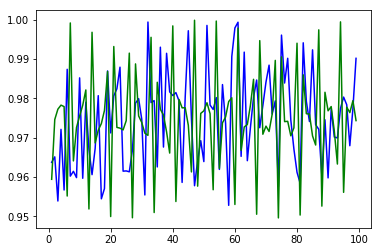

In [33]:
plt.plot(T_range, prob1, color = 'b')
plt.plot(T_range, prob2, color = 'g')
plt.show()

In [ ]:
psi_i = [1,0,0,0,0]
psi_T = np.dot(expm(-1j*H_t),psi_i)
print(psi_T)
print(np.absolute(psi_T))

#### Sanity Checks

In [13]:
x = op_x(5)
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

0.0

In [14]:
x = op_x(5)
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))

0.9600000000000002

In [15]:
x = op_x(5) 
vec1 = np.asarray([0,1,0,0,0])
vec2 = np.asarray([0,0,1,0,0])
(0.6)*(0.8)*(np.dot(vec1,np.dot(x,vec2)) + np.dot(vec2,np.dot(x,vec1)))

0.9600000000000002

In [26]:
x = op_x(5) - 3*np.eye(5) # subtracting 3*I
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

-3.0

In [17]:
x = op_x(5) - 3 # element wise subtraction
vec = np.asarray([1,0,0,0,0])
np.dot(vec,np.dot(x,vec))

-3.0

In [18]:
x = op_x(5) - 3*np.eye(5) # subtracting 3*I
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))

-2.04

In [19]:
x = op_x(5) - 3 # element wise subtraction
vec = np.asarray([0,0.6,0.8,0,0])
np.dot(vec,np.dot(x,vec))

-4.92